**Terminology**<br>
*Crossword page*: The entire sheet containing the crossword puzzle and clues. <br>
*Page pic*: A picture containing the crossword page. <br>
*Crossgrid*: The $15\times 15$ box on the crossword page. <br>
*Grid pic*: The region of the sheet pic containing the crossgrid. <br>
*Flatgrid*: The perspective-transformed grid pic. <br>
*Smallbox*: A single cell within the crossgrid, in which the user may write a single letter. <br>
*Black box*: A blackened smallbox. <br>
*Clue*: The hint text associated with a word. <br>
*Cluenum*: The number of a clue. In some cases one number may apply to 2 clues (across and down).<br>
*Cluetype*: Direction of a word: across or down. <br>
*ClueID*: The cluenum and cluetype identifying a clue. <br>
*Cluebox*: A box on the crossword page containing clues. 2 clueboxes per crossword page: one for across clues and one for down clues.<br>
*Grid coordinates*: $(y,x)$ coordinates in range $(0..14, 0..14)$ indicating the location of a smallbox within the crossgrid. $(0,0)$ is the box containing cluenum 1. <br>
*Pixel coordinates*: $(y,x)$ coordinates indicating a pixel in an image, with $(0,0)$ at the top left of the image. <br>
*Known letters*: A string containing known information about a word. For example, if we know it's 5 letters and the second letter is B, then the known letters are `'?B???'`. <br>

In [174]:
import pytesseract as pt
pt.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
import pandas as pd

maxclues = 3 #max number of digits of a clue number

**Ignore for now**<br>
`clue_dict` takes a cropped "across" or "down" image of clues (don't crop the word "across" or "down" out of the image). <br>
Returns an assertion error if the clue numbers are unreadable. <br>
Otherwise, returns a dictionary `cluedict` mapping clue number to clue text. <br>
Example: `cluedict['53ACROSS'] = 'whatever the clue is for 53 across'`

In [158]:
def clue_dict(imgpath): #img is string of image path
    
    #read clues and split them up by line
    text = pt.image_to_string(Image.open(imgpath))
    text = text.split('\n\n')
    
    #determine direction of clues in img
    if 'ACROSS' in text[0]:
        direction = 'ACROSS'
        del text[0]
    elif 'DOWN' in text[0]:
        direction = 'DOWN'
        del text[0]
    else: 
        direction = 'UNKNOWN'
        
    cluedict = {} #dictionary mapping clue number/direction to clue text
    
    for pos, clue in enumerate(text): #for each clue:
        
        #get rid of newlines within a single clue
        clue = clue.replace('\n', ' ')
        
        #figure out the clue number vs. the clue itself
        cluestartpos = clue.find(') ')
        numstart = cluestartpos
        for i in reversed(range(cluestartpos)):
            if clue[i].isnumeric():
                numstart = i
            else: break
                
        assert 0 < cluestartpos - numstart <= maxclues, 'Cannot read clue number: ' + clue
        
        print(cluenum, clue[cluestartpos + 2:], '\n')
        cluedict[cluenum] = clue[cluestartpos + 2:]
    
    return cluedict

**Ignore for now**<br>
Contains several simple functions that might be useful later on. <br>
`bilateral_blur(img)` smooths the image along the edges. <br>
`canny(img)` returns binary image found by canny edge detection. <br>
`show(img)` just plots the image using matplotlib. <br>
`pHoff(img)` returns probabilistic line transform. <br>

In [159]:
img = cv2.imread('pic.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def bilateral_blur(img):
    blur = cv2.bilateralFilter(img,13,9,9)
    return blur
    #cv2.imwrite('gaussian_blur.jpg',blur,)
    
def canny(img): 
    return cv2.Canny(img, 255, 255)

def show(img):
    plt.imshow(img, cmap = 'gray')
    
def pHoff(img='pic.jpg'):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #(thresh, im_bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    #im_bw = cv2.threshold(gray, 126, 255, cv2.THRESH_BINARY)[1]

    #edges = cv2.Canny(gray,100,200,apertureSize = 3)
    minLineLength = 100
    maxLineGap = 10
    lines = cv2.HoughLinesP(gray,1,np.pi/180,100,minLineLength,maxLineGap)
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

    return lines

pHoff()
#cv2.imwrite('houghlines5.jpg',pHoff('pic.jpg'))

array([[[   0,  661, 3095, 3756]],

       [[1254, 1913, 3095,   72]],

       [[   0, 3836,  250, 3586]],

       ...,

       [[ 846, 1527,  866, 1547]],

       [[1273, 1938, 1300, 1965]],

       [[2043, 2698, 2053, 2708]]], dtype=int32)

`corner_crop` takes an original image, and a 2D nparray of 4 pixel coordinates within the bounds of the image. <br><br>
The image returned is the smallest bounding rectangle of the coordinates. If the coordinates given form a non-rectangular quadrilateral, then the regions outside this quadrilateral are blackened in the image returned. <br><br>
For each row of the pixel coordinate array, the first entry should be the y-coordinate and the second entry should be the x-coordinate where $(0,0)$ is the top left of the image. The first row should be the upper left coordinate, second row should be upper right, third row should be lower right, and fourth row should be lower left.

In [160]:
def corner_crop(imgpath, corners): #corners is 2D nparray. 4 rows, one for each coordinate. 
    corners = np.flip(corners, axis=1)
    img = cv2.imread(imgpath)
    x, y, w, h = cv2.boundingRect(corners)
    smallimg = img[y:y+h, x:x+w].copy()
    
    corners -= corners.min(axis=0)
    mask = np.zeros(smallimg.shape[:2], np.uint8)
    cv2.drawContours(mask, [corners], -1, (255,255,255), -1, cv2.LINE_AA)
    
    dst = cv2.bitwise_and(smallimg, smallimg, mask=mask)
    
    return dst

corners = np.array([[2120,240], [2115,1840], [3800,1890], [3830,150]])
cv2.imwrite('cropp.jpg', corner_crop('pic.jpg', corners))

True

**Ignore this; its only purpose is visualization.**

`markPixel` just returns an new image, identical to the image at `impath` but with a rectangular dot added. The dot is centered at the coordinates given by `pixel`, which is a tuple with order (y,x). The dot's side-length is `mark_size` pixels. The dot's grayscale color is an int in range 0..255 given by `dot_value`.

In [161]:
def markPixel(imgpath, pixel, mark_size=30, dot_value=255):
    y, x = pixel
    img = cv2.imread(imgpath)
    r = mark_size // 2 #mark radius
    img[y-r:y+r+1, x-r:x+r+1] = 255
    
    return img

cv2.imwrite('cropp.jpg', markPixel('pic.jpg', (3830,150)))

True

`flatten` takes a quadrilateral region of image `impath` and returns a cropped, perspective-flattened verison of that region. <br><br>
The quadrilaterial is specified by coordinates `corners`, which is a 2D nparray. For each row of `corners`, the first entry should be the y-coordinate and the second entry should be the x-coordinate where $(0,0)$ is the top left of the original image. The first row should be the upper left coordinate, second row should be upper right, third row should be lower right, and fourth row should be lower left.

In [162]:
corners = np.array([[2120,240], [2115,1840], [3800,1890], [3830,150]]) #corners of crossword puzzle before transform

def flatten(imgpath, corners):
    newCorners = np.array([[0,0], [0, 999], [999, 999], [999, 0]])

    corners = np.flip(corners, axis=1)
    newCorners = np.flip(newCorners, axis=1)
    img = cv2.imread(imgpath)
    h, status = cv2.findHomography(corners, newCorners)
    return cv2.warpPerspective(img, h, (1000,1000))

cv2.imwrite('cropp.jpg', flatten('pic.jpg', corners))

True

Given a flatgrid at `imgpath` (as returned by the function `flatten`), and matrix coordinates `i`, `j` of the desired smallbox, `get_smallbox` returns the smallbox as an image. 

In [168]:
def get_smallbox(imgpath, i, j): #imgpath is the path of the transformed crossword grid
    imgsize = 1000
    i1, i2 = int(i * imgsize / 15), int((i+1) * imgsize / 15)
    j1, j2 = int(j * imgsize / 15), int((j+1) * imgsize / 15)
    smallCorners = np.array([[i1, j1], [i2, j1], [i2, j2], [i1, j2]])
    smallImg = corner_crop(imgpath, smallCorners)
    return cv2.cvtColor(smallImg, cv2.COLOR_BGR2GRAY)

cv2.imwrite('small.jpg', get_smallbox('cropp.jpg', 1, 10))

True

Given a flatgrid at `imgpath`, `black_coords` returns a 2D nparray whose rows are the grid coordinates of all black boxes. 

In [169]:
def black_coords(imgpath): #imgpath is the path of the transformed crossword grid
    data = np.zeros((15, 15))
    for i in range(15):
        for j in range(15):
            data[i, j] = getSquare('cropp.jpg', i, j).mean()

    sortedData = np.msort(data.flatten()) #sorted mean values
    shifted = np.append(sortedData, sortedData[-1]) #shifted has something at end of array
    diffs = shifted - np.insert(sortedData, 0, sortedData[0])
    numblack = np.argmax(diffs) #tells us how many black boxes there are
    threshold = np.mean(sortedData[numblack - 1:numblack+1])
    blackboxes = np.where(data < threshold)
    return np.concatenate((blackboxes[0].reshape(-1,1), blackboxes[1].reshape(-1,1)), axis=1)

blacks = black_coords('cropp.jpg')

Given a 2D nparray as returned by `black_coords`, `blacks_to_grid` returns the crossgrid layout, and the word list. <br><br>
The crossgrid layout is a $15\times 15$ nparray, each value representing the smallbox with corresponding grid coordinates. Value 255 indicates a black box, value 0 indicates a white box containing no cluenum, and other values are positive integers indicating the cluenum associated with that smallbox. <br><br>
The word list is a dictionary whose keys are clueIDs (e.g., `'5 Down'`), and values are the known letters of the word at that clueID (e.g., `'cro??word'`). Word list contains one entry for each clueID. 

In [170]:
def blacks_to_grid(blacks):
    printgrid = np.zeros((15, 15))
    printgrid[blacks[:,0],blacks[:,1]] = 255
    refgrid = copy.deepcopy(printgrid)
    counter, cluelist = 1, {}
    for i in range(15):
        for j in range(15):
            down, across = False, False
            if i==0 and refgrid[i,j]==0:
                down = True
            if j==0 and refgrid[i,j]==0:
                across = True
            if j > 0 and refgrid[i,j-1] == 255 and refgrid[i,j] == 0:
                across = True
            if i > 0 and refgrid[i-1,j] == 255 and refgrid[i,j] == 0:
                down = True
            if down:
                below = refgrid[i:15,j]
                if len(np.where(below==255)[0]) == 0:
                    word_len = 15 - i
                else: word_len = np.where(below==255)[0][0]
                cluelist[str(counter)+' Down'] = '?' * word_len
            if across: 
                below = refgrid[i,j:15]
                if len(np.where(below==255)[0]) == 0:
                    word_len = 15 - j
                else: word_len = np.where(below==255)[0][0]
                cluelist[str(counter)+' Across'] = '?' * word_len
            if down or across:
                printgrid[i,j] = counter
                counter += 1
    return printgrid, cluelist
        
printgrid, cluelist = blacks_to_grid(blacks)

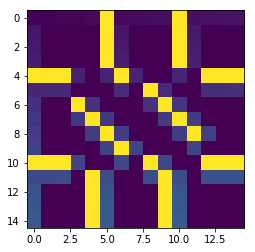

In [173]:
plt.imshow(printgrid)

In [172]:
cluelist

{'1 Down': '????',
 '1 Across': '?????',
 '2 Down': '????',
 '3 Down': '????',
 '4 Down': '??????',
 '5 Down': '???????',
 '6 Down': '????',
 '6 Across': '????',
 '7 Down': '???????????????',
 '8 Down': '?????',
 '9 Down': '??????',
 '10 Down': '????????',
 '10 Across': '????',
 '11 Down': '????',
 '12 Down': '????',
 '13 Down': '????',
 '14 Across': '?????',
 '15 Across': '????',
 '16 Across': '????',
 '17 Across': '?????',
 '18 Across': '????',
 '19 Across': '????',
 '20 Across': '?????',
 '21 Across': '????',
 '22 Across': '????',
 '23 Across': '???',
 '24 Down': '????',
 '25 Across': '?????',
 '26 Down': '???',
 '27 Down': '?????',
 '27 Across': '????????',
 '28 Down': '?????',
 '29 Down': '?????',
 '30 Down': '????',
 '31 Across': '??????',
 '32 Down': '?????',
 '33 Down': '?????',
 '34 Down': '?????',
 '35 Across': '???',
 '36 Across': '?????',
 '37 Down': '????',
 '38 Across': '?????',
 '39 Across': '????',
 '40 Down': '????????',
 '41 Across': '?????',
 '42 Down': '????',
 '43 

**NEXT STEPS**<br>
Compile the above functions into a class where the constructor takes in a page pic and creates a crossword object. Current capabilities:
* Access the crossgrid representation.
* Access the flattened image of any smallbox by giving coordinates.
* Access the list of clueIDs and known letters. 

**CAPABILITIES TO ADD:**
1. Given a page pic, locate the clue boxes, and OCR-read the clueIDs and clues. 
    * Given a clueID, return the clue text. 
    * Need to report errors to user if clue numbers are not distinguishable/readable. 
2. Given a clue's text and the known letters, get the solutions and confidences from dictionary.com tool. 
    * Need to account for cases when the tool says "No answers for that clue". 
3. Given a flattened smallbox, determine whether a letter has been written. 
    * If yes, then use the pretrained neural net to recognize the letter. 
    * This requires first getting rid of the cluenum (if applicable) before feeding image into neural net. 
    * We also may want to pad the image with a background value to fit the neural net's image size.
    
4. Have a way to edit the crossword object when a letter is read or a clue is solved. 
    * This should automatically update all known letter strings, and check for conflicts with existing information. 
5. Given multiple solutions and confidences for multiple clues, need a probabilistic way to resolve conflicts. 
    * Will be difficult. 
6. Need a graphical interface to incrementally report results to user (partially to understand where errors might have occurred). 
    1. Flattened pics of crossgrid and cluebox. 
    2. Digital representation of empty crossgrid. 
    3. OCR readings of clues. 
    4. Results of handwriting recognition. 
    5. Word guesses + confidences for each clue. 
    6. Letter guesses + confidences for each smallbox. 
    7. Final proposed solution (with some blank spaces if we couldn't complete the solution). 